<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/train_loop_refactor/notebooks/train_lfp_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q wandb pathy comet

     |████████████████████████████████| 3.1MB 7.7MB/s 
     |████████████████████████████████| 245kB 45.5MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 


In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment
import wandb
wandb.login()

wandb: Currently logged in as: tfrizza (use `wandb login --relogin` to force relogin)


True

In [2]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=50, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP


# ## Sample colab config
# args = parser.parse_args('''
# refactor_test
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -tfr
# -s GCS
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# --bucket_name iowa_bucket_lfp
# -i
# '''.split())

## Sample colab config
args = parser.parse_args('''
fit_test
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s DRIVE
-d TPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
-B 0.01
'''.split())

# -n 5
# -q 8

print(args)

Namespace(actor_layer_size=2048, batch_size=512, beta=0.01, bucket_name=None, colab=True, data_source='DRIVE', device='TPU', encoder_layer_size=512, fp16=False, from_tfrecords=False, gcbc=False, images=False, img_embedding_size=64, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=512, qbits=None, resume=False, run_name='fit_test', test_datasets=['UR5_slow_gripper_test'], tpu_name=None, train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=200000, window_size_max=50, window_size_min=20)


## Init

In [3]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/learning_from_play' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No pybullet installation found - which is fine if training
Reading data from Google Drive
Storage path: /content/drive/My Drive/Robotic Learning


In [4]:
print("Tensorflow version " + tf.__version__)

if args.device == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=args.tpu_name)  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
    if args.fp16:
        tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
        if args.fp16:
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
    strategy = tf.distribute.get_strategy()
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.109.249.170:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.109.249.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.249.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
# Use this to edit modules without needing to restart the kernel (can also edit local, push/pull)
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)
importlib.reload(lfp.metric)

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/sholtodouglas/learning_from_play
   b4427ea..f7beb96  master     -> origin/master
Updating b4427ea..f7beb96
Fast-forward
 lfp/plotting.py        |  36 ++-
 lfp/train.py           |   6 +-
 notebooks/Deploy.ipynb | 712 ++++++++++++++++---------------------------------
 train_lfp.py           |   2 +-
 4 files changed, 261 insertions(+), 495 deletions(-)


<module 'lfp.metric' from '/content/learning_from_play/lfp/metric.py'>

## Data

In [5]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=GLOBAL_BATCH_SIZE,  window_size=args.window_size_max, min_window_size=args.window_size_min)

In [6]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:00<00:00, 48.76it/s]


{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


In [7]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 38.58it/s]

{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


# Training Loop

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda, \
    Bidirectional, GRU, LayerNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.metrics import Mean
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

ACT_LIMITS = tf.constant([1.5, 1.5, 2.2, 3.2, 3.2, 3.2, 1.1])

def create_actor(obs_dim, act_dim, goal_dim, layer_size=1024, latent_dim=256, training=True):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, obs_dim), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, goal_dim), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    x = Concatenate(axis=-1)([o, z, g])
    x = Masking(mask_value=0.)(x)
    x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1')(x)
    x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2')(x)

    # Deterministic output #
    actions = Dense(act_dim, activation='tanh', name='acts')(x)
    actions = Lambda(lambda a: a * ACT_LIMITS)(actions) # scale to action limits
    return Model([o, z, g], actions)


def create_encoder(obs_dim, act_dim, layer_size=2048, latent_dim=256):
    # Input #
    obs = Input(shape=(None, obs_dim), dtype=tf.float32, name='obs')
    acts = Input(shape=(None, act_dim), dtype=tf.float32, name='acts')

    # Layers #
    x = Concatenate(axis=-1)([obs, acts])
    x = Masking(mask_value=0.)(x)
    x = Bidirectional(LSTM(layer_size, return_sequences=True), merge_mode='concat')(x)
    x = Bidirectional(LSTM(layer_size, return_sequences=False), merge_mode='concat')(x)

    # Latent Variable #
    x = Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None)(x),
    z = tfpl.MultivariateNormalTriL(latent_dim, name='latent')(x)
    return Model([obs, acts], z)


def create_planner(obs_dim, goal_dim, layer_size=2048, latent_dim=256):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(obs_dim,), batch_size=batch_size, dtype=tf.float32,
                name='initial_obs')  # has arm state
    o_g = Input(shape=(goal_dim,), batch_size=batch_size, dtype=tf.float32,
                name='goal_obs')  # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x) # maybe change to selu/gelu/swish?
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    x = Dense(layer_size, activation="relu", name='layer_4')(x)

    # Latent Variable #
    x = Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None)(x),
    z = tfpl.MultivariateNormalTriL(latent_dim, name='latent')(x)
    return Model([o_i, o_g], z)

# Todo: add beta callback, add checkpointing callback, think about train=False autoregressive, what to do about masking?
class LFPNet(Model):
    def __init__(self, encoder, planner, actor, beta) -> None:
        super(LFPNet, self).__init__()
        self.encoder = encoder
        self.planner = planner
        self.actor = actor
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.action_loss_tracker = Mean(name="action_loss")
        self.reg_loss_tracker = Mean(name="reg_loss")

    def call(self, inputs, planner=True, training=False):
        if planner:
            z = self.planner([inputs['obs'][:,0,:], inputs['goals'][:,0,:]])
        else:
            z = self.encoder([inputs['obs'], inputs['acts']])
        z_tiled = tf.tile(tf.expand_dims(z[0], 1), (1, inputs['obs'].shape[1], 1))
        acts = self.actor([inputs['obs'], z_tiled, inputs['goals']])
        return acts, z

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            acts_enc, z_enc = self(inputs, planner=False, training=True)
            acts_plan, z_plan = self(inputs, planner=True, training=True)
            act_loss = self.compiled_loss(inputs['acts'], acts_enc, regularization_losses=self.losses)
            reg_loss = tfd.kl_divergence(z_enc, z_plan)
            loss = act_loss + self.beta * reg_loss

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update metrics (includes the metric that tracks the loss)
        self.total_loss_tracker.update_state(loss)
        self.action_loss_tracker.update_state(act_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        result = {m.name: m.result() for m in self.metrics}
        result['beta'] = self.beta
        return result

    def test_step(self, inputs):
        acts_enc, z_enc = self(inputs, planner=False, training=False)
        acts_plan, z_plan = self(inputs, planner=True, training=False)
        act_loss = self.compiled_loss(inputs['acts'], acts_plan, regularization_losses=self.losses)
        reg_loss = tfd.kl_divergence(z_enc, z_plan)
        loss = act_loss + self.beta * reg_loss

        # Update metrics (includes the metric that tracks the loss)
        self.total_loss_tracker.update_state(loss)
        self.action_loss_tracker.update_state(act_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {m.name: m.result() for m in self.metrics}

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.action_loss_tracker,
            self.reg_loss_tracker
        ]

In [9]:
with strategy.scope():
    actor = create_actor(obs_dim=dl.obs_dim, act_dim=dl.act_dim, goal_dim=dl.goal_dim, layer_size=args.actor_layer_size, latent_dim=args.latent_dim)
    encoder = create_encoder(obs_dim=dl.obs_dim, act_dim=dl.act_dim, layer_size=args.encoder_layer_size, latent_dim=args.latent_dim)
    planner = create_planner(obs_dim=dl.obs_dim, goal_dim=dl.goal_dim, layer_size=args.encoder_layer_size, latent_dim=args.latent_dim)

    model = LFPNet(encoder, planner, actor, beta=args.beta)

    optimizer = tf.keras.optimizers.Adam(args.learning_rate)
    model.compile(optimizer=optimizer, loss='mse', steps_per_execution=1, run_eagerly=False)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [10]:
class BetaSchedulerCallback(tf.keras.callbacks.Callback):
    """ For some reason this doesn't seem to work :/ """
    def __init__(self, schedule):
        super(BetaSchedulerCallback, self).__init__()
        self.schedule = schedule

    def on_train_batch_begin(self, step, logs=None):
        if not hasattr(self.model, "beta"):
            raise ValueError('Optimizer must have a "beta" attribute.')
        # Get the current learning rate from model's optimizer.
        # beta = float(tf.keras.backend.get_value(self.model.beta))
        # Call schedule function to get the scheduled learning rate.
        scheduled_beta = float(self.schedule(step))
        # Set the value back to the optimizer before this epoch starts
        # tf.keras.backend.set_value(self.model.beta, scheduled_beta)
        self.model.beta = scheduled_beta
        print(f"\nStep {step:05}: Beta is {self.model.beta:.1e}.")

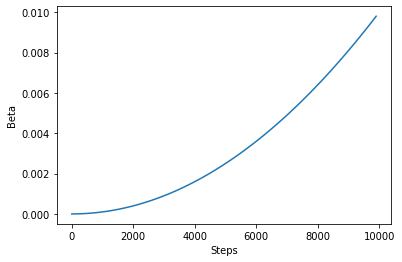

In [11]:
beta_schedule = lfp.train.BetaScheduler('quadratic', beta_max=args.beta)

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=STORAGE_PATH/'saved_models', monitor='val_total_loss', save_best_only=True, save_weights_only=False, save_freq=1000
)

In [20]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=1,
                    steps_per_epoch=10,
                    validation_steps=10,
                    callbacks=[BetaSchedulerCallback(beta_schedule.scheduler), checkpoint_callback])


Step 00000: Beta is 0.0e+00.
 1/10 [==>...........................] - ETA: 14:17 - total_loss: 0.0079 - action_loss: 0.0079 - reg_loss: 252.7350 - beta: 0.0000e+00
Step 00001: Beta is 1.0e-10.
 2/10 [=====>........................] - ETA: 15s - total_loss: 0.0189 - action_loss: 0.0189 - reg_loss: 240.1346 - beta: 0.0000e+00  
Step 00002: Beta is 4.0e-10.
 3/10 [========>.....................] - ETA: 13s - total_loss: 0.0452 - action_loss: 0.0452 - reg_loss: 229.7152 - beta: 0.0000e+00
Step 00003: Beta is 9.0e-10.
 4/10 [===========>..................] - ETA: 11s - total_loss: 0.0606 - action_loss: 0.0606 - reg_loss: 231.6647 - beta: 0.0000e+00
Step 00004: Beta is 1.6e-09.
 5/10 [==============>...............] - ETA: 9s - total_loss: 0.0727 - action_loss: 0.0727 - reg_loss: 240.4555 - beta: 0.0000e+00 
Step 00005: Beta is 2.5e-09.
 6/10 [=================>............] - ETA: 7s - total_loss: 0.0759 - action_loss: 0.0759 - reg_loss: 240.2937 - beta: 0.0000e+00WARNING:tensorflow:Callba


Step 00006: Beta is 3.6e-09.
 7/10 [====================>.........] - ETA: 5s - total_loss: 0.0696 - action_loss: 0.0696 - reg_loss: 246.5844 - beta: 0.0000e+00
Step 00007: Beta is 4.9e-09.
 8/10 [=======================>......] - ETA: 3s - total_loss: 0.0888 - action_loss: 0.0888 - reg_loss: 246.1942 - beta: 0.0000e+00
Step 00008: Beta is 6.4e-09.
 9/10 [==========================>...] - ETA: 1s - total_loss: 0.1031 - action_loss: 0.1031 - reg_loss: 426.5930 - beta: 0.0000e+00
Step 00009: Beta is 8.1e-09.
10/10 [==============================] - 168s 8s/step - total_loss: 0.1296 - action_loss: 0.1296 - reg_loss: 1926.2640 - beta: 0.0000e+00 - val_total_loss: 0.1711 - val_action_loss: 0.1709 - val_reg_loss: 26089.3867


In [22]:
history.history

{'action_loss': [0.12956753373146057],
 'beta': [0.0],
 'reg_loss': [1926.2640380859375],
 'total_loss': [0.12956753373146057],
 'val_action_loss': [0.17088711261749268],
 'val_reg_loss': [26089.38671875],
 'val_total_loss': [0.17109845578670502]}